#### Rutas

In [25]:
import os
# nos ubicamos en el directorio s
cur_path = os.getcwd()
if cur_path.endswith("notebooks"):
    cur_path = cur_path + "/.."
os.chdir(cur_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/exodia/Documentos/TFBigData


#### Librerias

In [26]:
import pyarrow.parquet as pq
import pandas as pd
import h2o
from h2o.frame import H2OFrame

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


import src.utils as utils


## Carga de datos

[Danish Residential Housing Prices 1992-2024](https://www.kaggle.com/datasets/martinfrederiksen/danish-residential-housing-prices-1992-2024/data) 

In [27]:
data_path = "data/DKHousingPrices.parquet"



In [28]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,15 hours 32 mins
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 9 days
H2O_cluster_name:,H2O_from_python_exodia_ycvqsg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.670 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [29]:
df_h2o = h2o.import_file(
                path   = data_path,
                header = 1,
                sep    = ",",
                destination_frame = "datos_h2o"
            )
print(df_h2o.shape) 


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(1507908, 19)


### Inspección general

In [30]:
print(f"El dataset tiene {df_h2o.shape[0]:,} filas")
print(f"El dataset tiene {df_h2o.shape[1]:,} columnas")

El dataset tiene 1,507,908 filas
El dataset tiene 19 columnas


In [31]:
df_h2o.head()


date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
1.7299e+18,219,0,Villa,regular_sale,1974,4.35e+06,0,5,215,20232.6,Kildevangen 5,8382,Hinnerup,East & mid jutland,Jutland,3.1,nan,nan
1.7299e+18,219,2,Summerhouse,regular_sale,1956,450000,0,3,36,12500,Lykkestien 2,4400,Kalundborg,Other islands,Zealand,3.1,nan,nan
1.7299e+18,219,1,Farm,regular_sale,1955,6.6e+06,0,3,180,36666.7,Sæderupvej 58,9260,Gistrup,North jutland,Jutland,3.1,nan,nan
1.72981e+18,219,3,Apartment,family_sale,1945,1.495e+06,0,2,64,23359.4,"Tage-Hansens Gade 5, 1. tv",8000,Aarhus C,East & mid jutland,Jutland,3.1,nan,nan
1.72981e+18,219,4,Villa,regular_sale,1967,3.375e+06,0,5,176,19176.1,Chr.Winthers Vej 5,8600,Silkeborg,East & mid jutland,Jutland,3.1,nan,nan
1.72973e+18,219,14,Villa,regular_sale,1979,3e+06,0,6,208,14423.1,Vesterled 7,8300,Odder,East & mid jutland,Jutland,3.1,nan,nan
1.72973e+18,219,23,Villa,regular_sale,2014,4.535e+06,-3,6,189,23994.7,Mosevang 10,7300,Jelling,South jutland,Jutland,3.1,nan,nan
1.72973e+18,219,22,Summerhouse,regular_sale,1979,1.1e+06,-8,3,70,15714.3,Rønnebærvænget 3,6094,Hejls,South jutland,Jutland,3.1,nan,nan
1.72973e+18,219,20,Summerhouse,regular_sale,1979,1.07e+06,-2,4,76,14078.9,Olymposvej 23,4200,Slagelse,Other islands,Zealand,3.1,nan,nan
1.72973e+18,219,19,Villa,family_sale,1923,360000,0,4,96,3750,Vesterled 27,6851,Janderup Vestj,South jutland,Jutland,3.1,nan,nan


In [32]:
df_h2o.types

{'date': 'int',
 'quarter': 'int',
 'house_id': 'int',
 'house_type': 'enum',
 'sales_type': 'enum',
 'year_build': 'int',
 'purchase_price': 'int',
 '%_change_between_offer_and_purchase': 'int',
 'no_rooms': 'int',
 'sqm': 'int',
 'sqm_price': 'real',
 'address': 'string',
 'zip_code': 'int',
 'city': 'enum',
 'area': 'enum',
 'region': 'enum',
 'nom_interest_rate%': 'real',
 'dk_ann_infl_rate%': 'real',
 'yield_on_mortgage_credit_bonds%': 'real'}

In [33]:
# Separar columnas numéricas y categóricas (H2O)
numeric_columns = [col for col, typ in df_h2o.types.items() if typ in ["int", "real"]]
categorical_columns = [col for col, typ in df_h2o.types.items() if typ not in ["int", "real"]]

assert len(numeric_columns) + len(categorical_columns) == df_h2o.ncols, "Hay columnas que no son ni numéricas ni categóricas"


In [34]:
df_h2o.describe()

Rows:1507908
Cols:19

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
type,int,int,int,enum,enum,int,int,int,int,int,real,string,int,enum,enum,enum,real,real,real
mins,6.945696e+17,88.0,0.0,,,1000.0,250010.0,-49.0,1.0,26.0,269.857421875,NaN,1050.0,,,,0.0,0.25,1.100000023841858
mean,1.3505940059876918e+18,170.69619035113948,753953.4999999874,,,1954.9426437157258,1915468.643398009,-2.0783608814330954,4.371574393132985,129.2527836615794,16345.245453792944,NaN,5959.594101894824,,,,1.6794227750923436,1.9299284800293093,4.112549228266287
maxs,1.7299008e+18,219.0,1507907.0,,,2024.0,46800000.0,49.0,15.0,997.0,75000.0,NaN,9990.0,,,,9.5,7.699999809265138,10.140000343322752
sigma,2.854076370449394e+17,36.17883308756796,435295.6891941376,,,45.8416853691144,1765653.841222887,4.809590406106,1.6504854621096037,57.1992461139101,13626.267159268897,NaN,2369.3190660346295,,,,2.042229492018218,1.6368003084456606,2.193449306606778
zeros,0,0,1,,,0,0,966554,0,0,0,0,0,,,,698458,0,0
missing,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,1193,1193
0,1.7299008e+18,219.0,0.0,Villa,regular_sale,1974.0,4350000.0,0.0,5.0,215.0,20232.558593750004,Kildevangen 5,8382.0,Hinnerup,East & mid jutland,Jutland,3.099999904632568,nan,nan
1,1.7299008e+18,219.0,2.0,Summerhouse,regular_sale,1956.0,450000.0,0.0,3.0,36.0,12500.0,Lykkestien 2,4400.0,Kalundborg,Other islands,Zealand,3.099999904632568,nan,nan
2,1.7299008e+18,219.0,1.0,Farm,regular_sale,1955.0,6600000.0,0.0,3.0,180.0,36666.66796875,Sæderupvej 58,9260.0,Gistrup,North jutland,Jutland,3.099999904632568,nan,nan


#### Tipos de datos

- Numéricos: `int`, `real` (`purchase_price`, `sqm`, `sqm_price`, etc.)
- Categóricos: `enum` tipo de vivienda, zona, región, etc. Texto `address`, `city` 
- Fechas: `date` está como `int` (probablemente timestamp entero) (formato danes(?))



#### Datos nulos (missing)

* `sqm` y `sqm_price`: 2 valores faltantes casi nulo
* `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`: 1193 faltantes


imputacion de valores macros. Fordward fill por trimestre




#### Datos sospechosos

- `%_change_between_offer_and_purchase`: contiene valores negativos y **966,554 ceros**  casi el 64% no tiene cambio en el precio vs. oferta -> (*h0:* Estos 0s corresponden a la primera venta h1: perdida de informacion h2: la casa fue vendida al mismo precio de compra)
- `year_build`: rango amplio (1000–2024), media 1954 -> se pueden filtrar o segmentar años aparentemente irreales (antes de 1800 por ejemplo)
- `purchase_price`: va de DKK 250,000 a más de 46 millones -> revisar posibles outliers en log escala
- `sqm_price`: mínimo de 269, máximo de 75,000 → revisar valores extremos


#### Medidas

1. `year_build` debe limpiarse. Establecer threshold)
1.  Hay pocos valores faltantes. Determinar, eliminar sin problema
1.  Deben detectarse duplicados
1. `purchase_price`, `sqm`, `sqm_price` el analisis univariado debe realizarse con histogramas/log
1. `date`  Agregar una columna con conversión a formato fecha real (desde timestamp largo)



In [35]:
numeric_columns

['date',
 'quarter',
 'house_id',
 'year_build',
 'purchase_price',
 '%_change_between_offer_and_purchase',
 'no_rooms',
 'sqm',
 'sqm_price',
 'zip_code',
 'nom_interest_rate%',
 'dk_ann_infl_rate%',
 'yield_on_mortgage_credit_bonds%']

In [36]:
categorical_columns

['house_type', 'sales_type', 'address', 'city', 'area', 'region']

### 2. Limpieza de datos

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df = df_h2o.as_data_frame(use_multi_thread=True) 

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


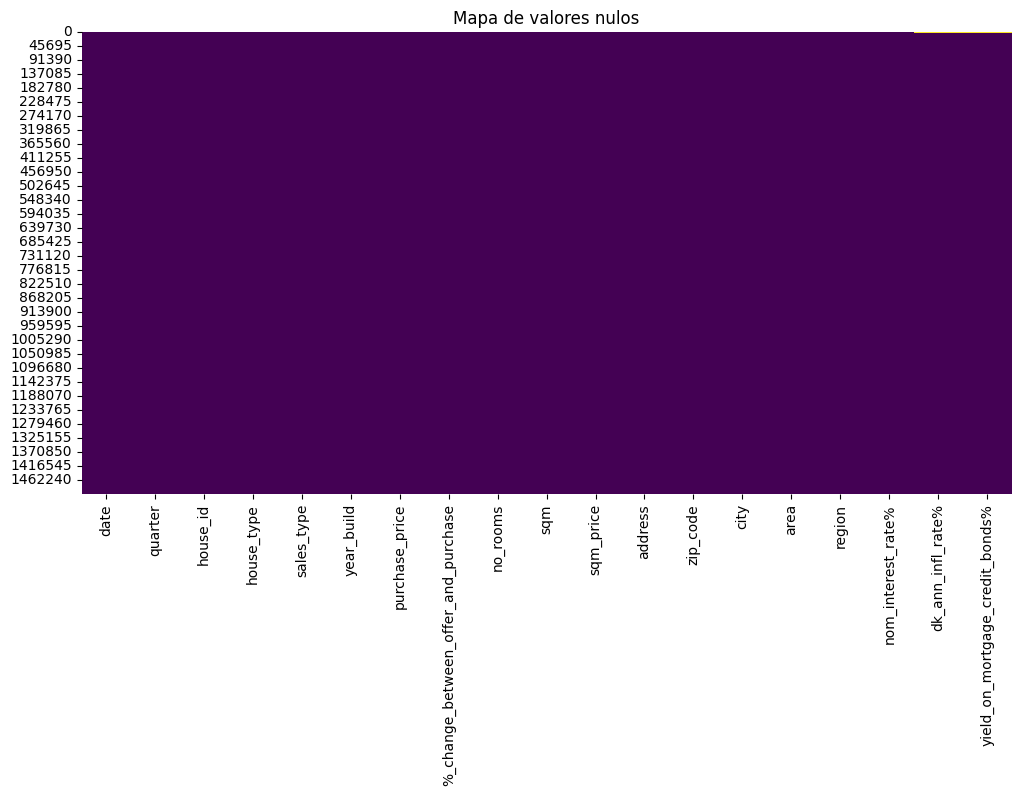

In [39]:

utils.plot_null_heatmap(df)

In [40]:
df_nulls, df_nulls_percentages = utils.get_df_null_resume_and_percentages(df)
df_nulls_percentages

,column,null_percentage
0,yield_on_mortgage_credit_bonds%,0.08 %
1,dk_ann_infl_rate%,0.08 %
2,city,0.01 %
3,sqm,0.00 %
4,sqm_price,0.00 %


Dataframe de registros con valores vacios
(1317, 19)


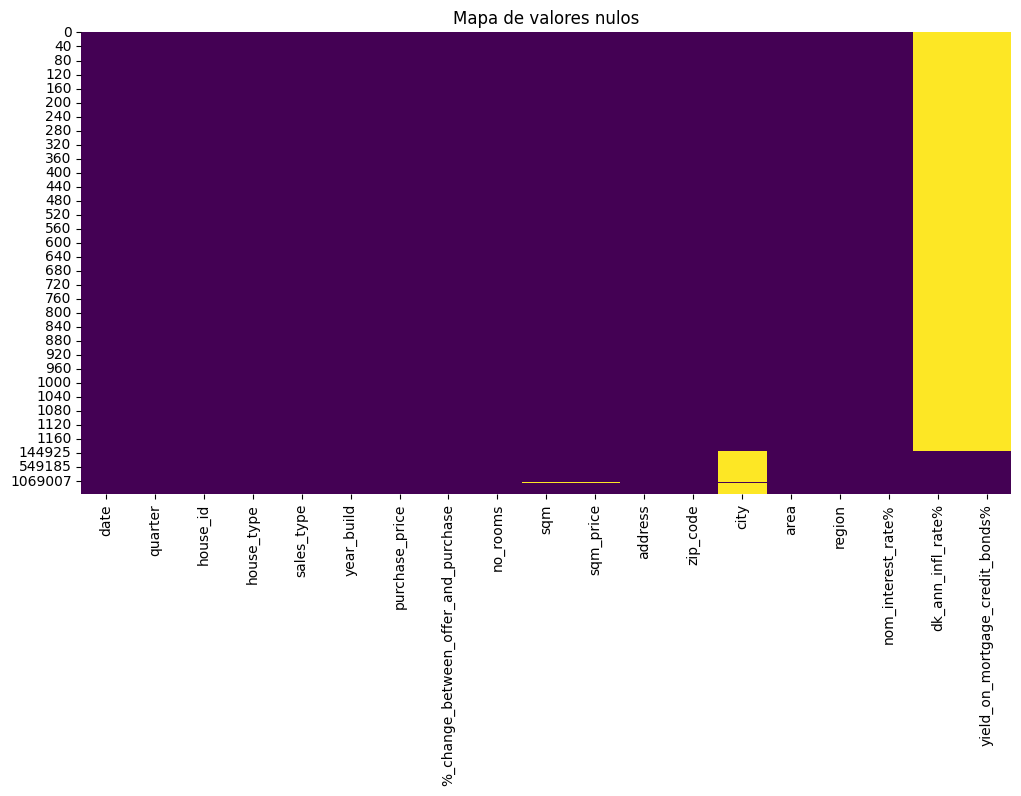

In [41]:
print("Dataframe de registros con valores vacios")
print(df_nulls.shape)
utils.plot_null_heatmap(df_nulls)

In [42]:
n = df.shape[0]
df = df.dropna(subset=["sqm", "sqm_price", "dk_ann_infl_rate%", "yield_on_mortgage_credit_bonds%"])
print(f"Eliminamos {n - df.shape[0]} registros con valores vacíos, quedando {df.shape[0]} registros. Representa un {100 * (n - df.shape[0]) / n:.2f}% de los datos originales.")
df_h2o = H2OFrame(df)

Eliminamos 1195 registros con valores vacíos, quedando 1506713 registros. Representa un 0.08% de los datos originales.
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Tratamiento de valores faltantes y duplicados

Al inspeccionar los valores nulos, se encontró que las variables `sqm`, `sqm_price`, `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`, al inspeccionar visualmente no se observo su precesencia, esto es debido a que se presentan proporciones extremadamente bajas de valores faltantes — todas por debajo del 0.08%.

La literatura aplicable a machine learning recomienda que si el porcentaje de datos faltantes es `<5%`, se dichos valores se pueden eliminar sin afectar la calidad del modelo. 

Estrategia aplicada:

Siguiendo a Bello (2023) se determinó el mecanismo de perdida de datos, asimismo se caracteriza el patrón de datos perdidos. Mediante un modelo de regresion o mediante patrones de información (visualización), para clasificarlos dentro de las siguientes categorias:

- Datos perdidos al azar (MAR)                      : Asociado a otra caracteristica del sujeto
- Datos perdidos completamente al azar (MCAR)       : No relacionado a un caracteristica o respuesta del sujeto.
- Valor faltante informativo (NMAR)                 : La tencia a que falte una variable es una funcion de los datos no disponibles


De forma independiente, al tratarse de una presencia menor al 0.1 %, se decide usar el método de análsis de casos completos (eliminando los casos), sin descuidar el análsis requerido para identificar la perdida de datos.


En caso el metodo fuera modificado posteriormente, se recomienda ,salvo se determie el mecanismo de perdida de datos (MAR o NMAR), como metodo de imputación multiple:

- Para `sqm` y `sqm_price`: se impute la **mediana**, robusta frente a outliers.
- Para `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`: se aplique **propagación hacia adelante** (forward fill), dada la continuidad temporal entre trimestres.



In [43]:
print("Valores duplicados por columna")
df_duplicates = df.duplicated().sum()
print(df_duplicates)

print("Duplicados por fila sin considerar 'house_id':")
df_duplicates_no_id = df[df.drop("house_id", axis=1).duplicated()]
print(df_duplicates_no_id.shape[0])  


Valores duplicados por columna


0
Duplicados por fila sin considerar 'house_id':
0


No se encontraron registros duplicados, consecuentemente no se tomaron medidas en este aspecto.

### Analisis Univariado

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


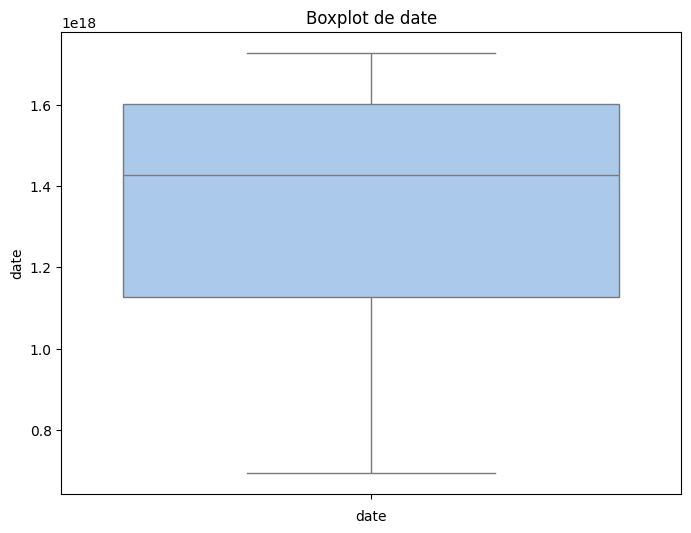

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


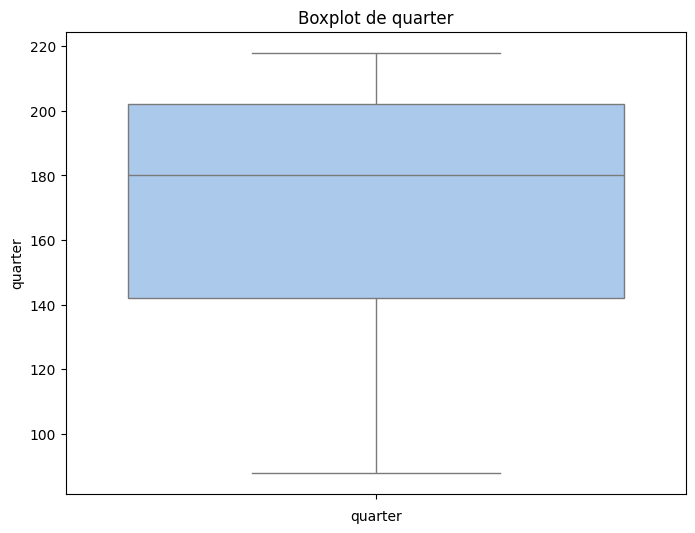

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


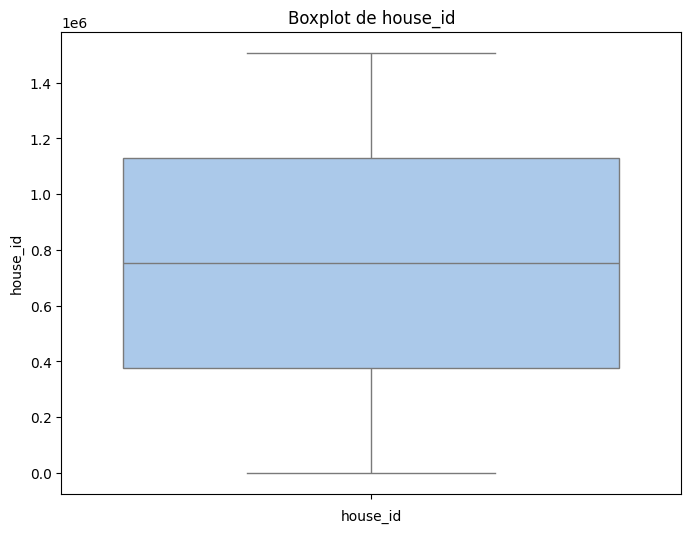

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


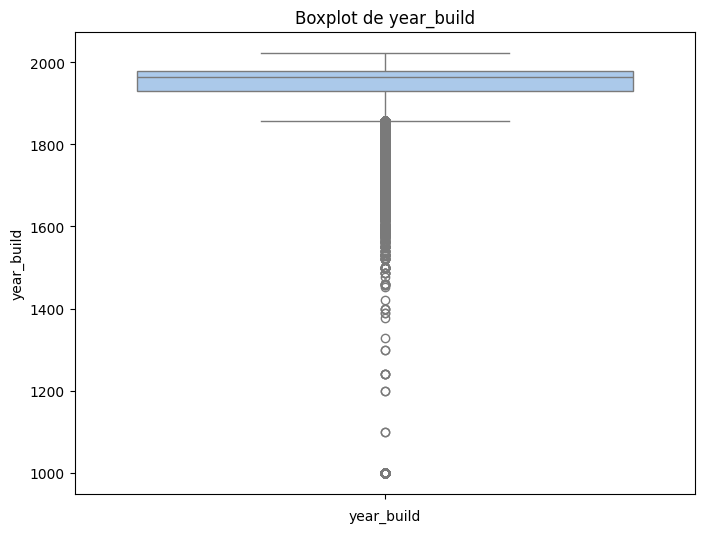

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


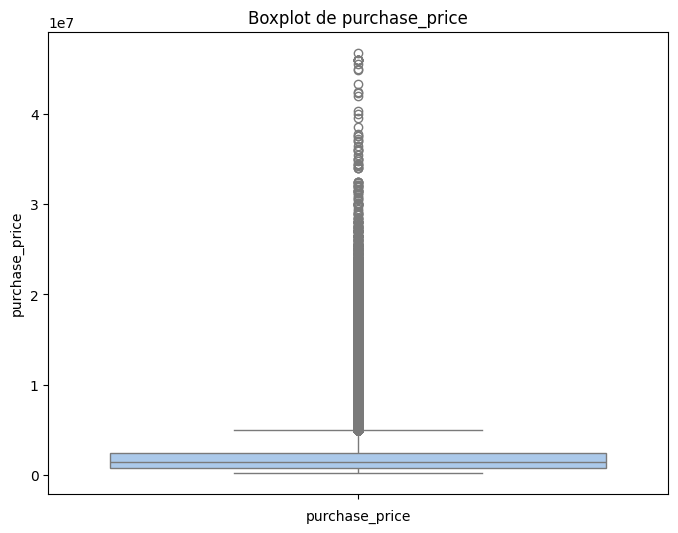

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


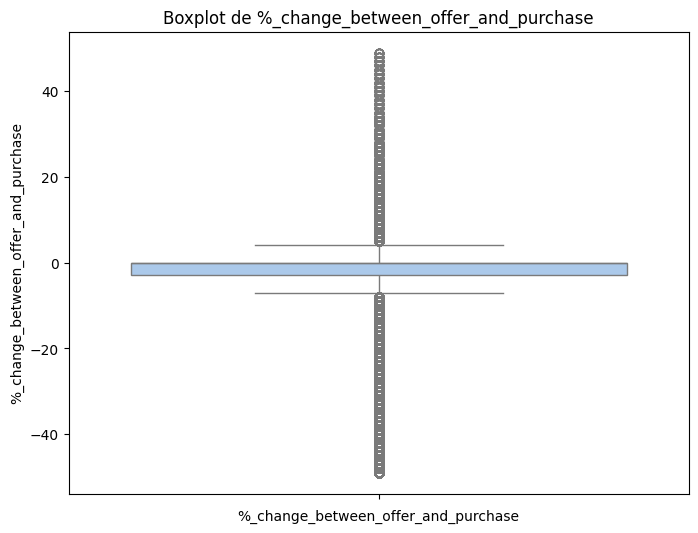

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


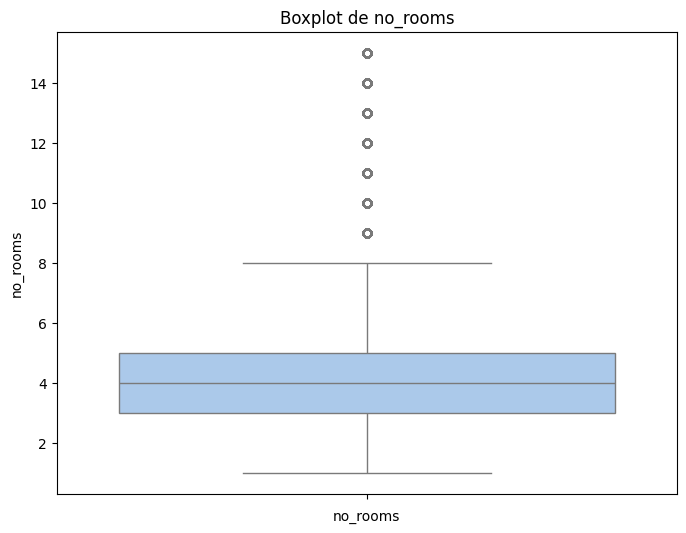

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


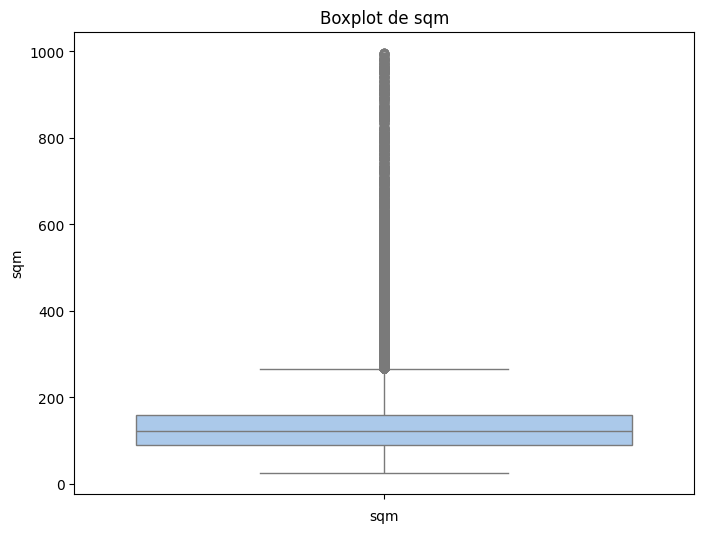

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


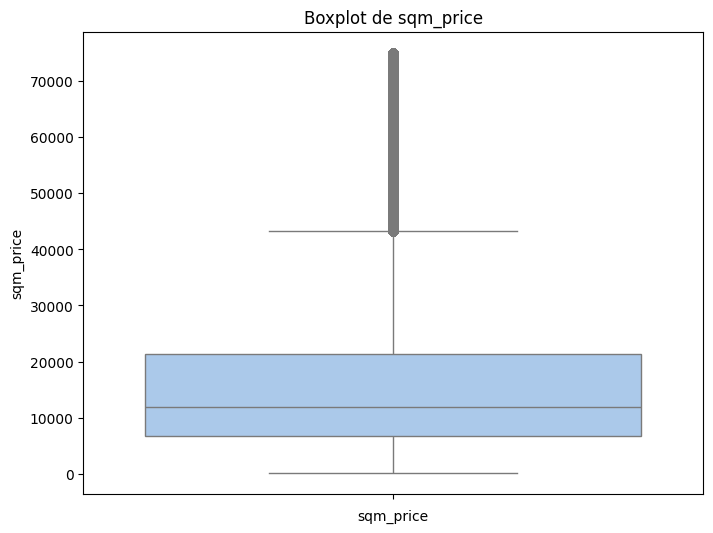

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


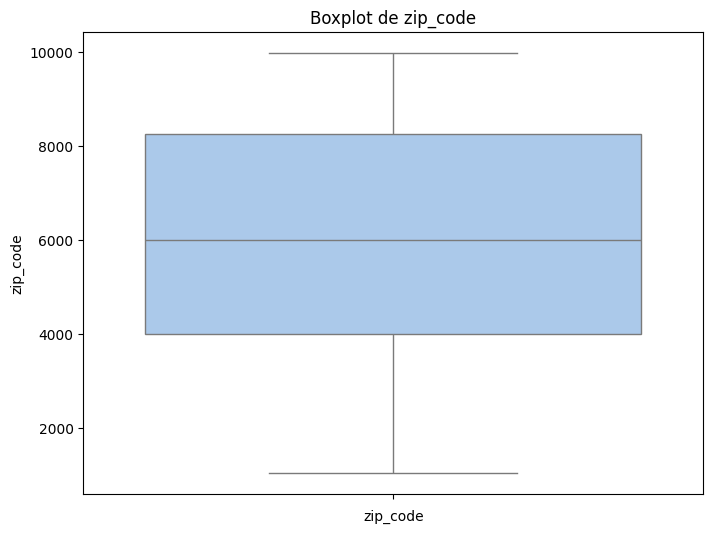

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


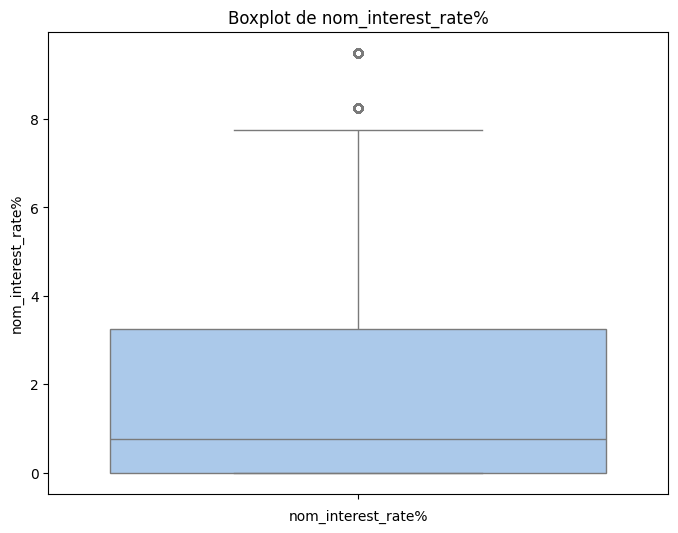

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


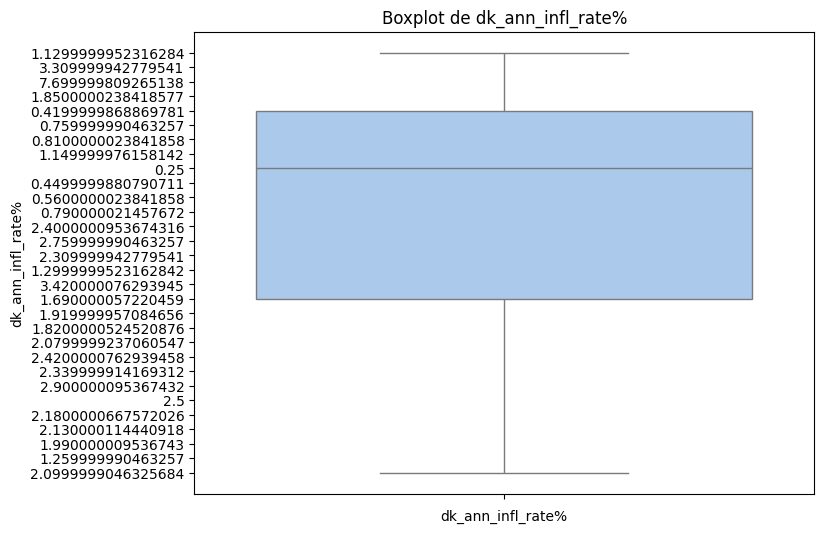

/tmp/ipykernel_393018/247919404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, y=col, palette='pastel')


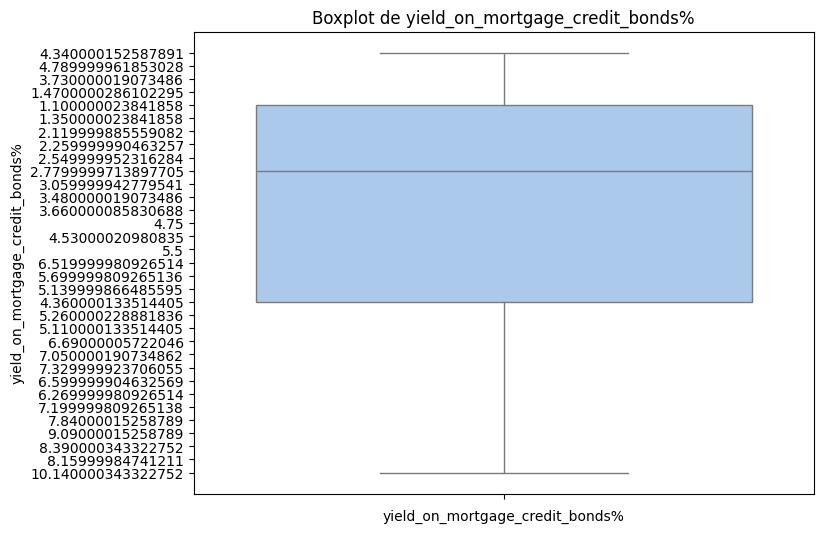

In [44]:
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df, y=col, palette='pastel')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

In [45]:
df_clean = df.copy()

# Imputar la mediana en variables numéricas directas
for col in ["sqm", "sqm_price"]:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Imputar forward fill para variables temporales macroeconómicas
for col in ["dk_ann_infl_rate%", "yield_on_mortgage_credit_bonds%"]:
    df_clean[col].fillna(method="ffill", inplace=True)


/tmp/ipykernel_393018/830630560.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
/tmp/ipykernel_393018/830630560.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [46]:
#assert df_clean.isna().sum().sum() == 0, "Todos los valores nulos no han sido imputados correctamente."

In [47]:
df_clean.isna().sum()

date                                     0
quarter                                  0
house_id                                 0
house_type                               0
sales_type                               0
year_build                               0
purchase_price                           0
%_change_between_offer_and_purchase      0
no_rooms                                 0
sqm                                      0
sqm_price                                0
address                                  0
zip_code                                 0
city                                   122
area                                     0
region                                   0
nom_interest_rate%                       0
dk_ann_infl_rate%                        0
yield_on_mortgage_credit_bonds%          0
dtype: int64

In [48]:

# Iniciar H2O y convertir a H2OFrame
h2o.init()
df_h2o = H2OFrame(df_clean)

# Verifica que todo esté bien
df_h2o.describe()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,15 hours 32 mins
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 9 days
H2O_cluster_name:,H2O_from_python_exodia_ycvqsg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.751 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:1506713
Cols:19

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
type,int,int,int,enum,enum,int,int,int,int,int,real,string,int,enum,enum,enum,real,real,real
mins,6.945696e+17,88.0,1193.0,,,1000.0,250010.0,-49.0,1.0,26.0,269.857421875,NaN,1050.0,,,,0.0,0.25,1.100000023841858
mean,1.3502947433126282e+18,170.65793551923963,754550.1496509287,,,1954.9439222997355,1915212.932007622,-2.0777467241604732,4.371835910355854,129.2631994281592,16341.576108724246,NaN,5959.671776244048,,,,1.67829838068546,1.9299246570432407,4.112548800247499
maxs,1.7276544e+18,218.0,1507907.0,,,2024.0,46800000.0,49.0,15.0,997.0,75000.0,NaN,9990.0,,,,9.5,7.699999809265138,10.140000343322752
sigma,2.8532243839903648e+17,36.16760758921834,434951.2731831351,,,45.844436503446694,1765414.3166098648,4.808343997592785,1.6504973982389906,57.199811321673174,13623.470013858587,NaN,2369.3648929327505,,,,2.04264715363471,1.6367946447094144,2.193450580540579
zeros,0,0,0,,,0,0,965838,0,0,0,0,0,,,,698457,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.7276544e+18,218.0,1300.0,Apartment,regular_sale,1971.0,1765000.0,0.0,3.0,78.0,22628.205078125,"Hedekæret 38, 1. th",2640.0,Hedehusene,"Capital, Copenhagen",Zealand,3.349999904632568,1.1299999952316284,4.340000152587891
1,1.7276544e+18,218.0,1307.0,Summerhouse,regular_sale,2009.0,590939.0,0.0,3.0,50.0,11818.7802734375,Violstien 11,2635.0,Ishøj,"Capital, Copenhagen",Zealand,3.349999904632568,1.1299999952316284,4.340000152587891
2,1.7276544e+18,218.0,1301.0,Apartment,regular_sale,1940.0,1750000.0,0.0,2.0,56.0,31250.0,"Buddingevej 72I, st. tv",2800.0,Kongens Lyngby,"Capital, Copenhagen",Zealand,3.349999904632568,1.1299999952316284,4.340000152587891


In [49]:
categorical_columns.remove("date")  # Eliminamos la columna de fecha, no es categórica

ValueError: list.remove(x): x not in list

In [ ]:

for col in categorical_columns:
    print(f"Convirtiendo {col} a factor")
    try:
        df_h2o[col] = df_h2o[col].asfactor()
    except Exception as e:
        print(f"Error al convertir {col} a factor: {e}")

Convirtiendo quarter a factor
Convirtiendo house_type a factor
Convirtiendo sales_type a factor
Convirtiendo address a factor
Convirtiendo city a factor
Convirtiendo area a factor
Convirtiendo region a factor


In [ ]:

# Variables finales
target = "purchase_price"
features = [col for col in df_h2o.columns if col != target and col != "date"]

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.automl import H2OAutoML

train, test = df_h2o.split_frame(ratios=[0.8])


In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm = H2OGeneralizedLinearEstimator()
glm.train(x=features, y=target, training_frame=train)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1751683458838_1


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 269860.0 )  1121893                       10                             2                       py_29_sid_8eb6

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 3128039130498.8755
RMSE: 1768626.3399878663
MAE: 1188387.3498518085
RMSLE: 0.8410976226111424
Mean Residual Deviance: 3128039130498.8755
R^2: 1.113525370710633e-05
Null degrees of freedom: 1206453
Residual degrees of freedom: 1206443
Null deviance: 3.7738773442286223e+18
Residual deviance: 3.77383532114689e+18
AIC: 38135195.86896942

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  ---------------------
    2025-07-04 21:44:42  0.000 sec   0             3.7738773437329715e+18     3128073961985.2656
    2025-07-04 21:44:42  0.594 sec   2                                                            1768626.3399878663  3128039130498.8755   1188387.3498518085  1.113525370710633e-05

Variable Importances: 
variable                             relative_importance    scaled_importance     percentage
-----------------------------------  ---------------------  --------------------  --------------------
sqm_price                            8.999921798706055      1.0                   0.4080915035061963
house_id                             2.707385301589966      0.30082320292818704   0.12276339317251343
sqm                                  2.320648670196533      0.2578520927293146    0.10522724820412512
zip_code                             2.1838700771331787     0.24265433922405416   0.09902517412624684
yield_on_mortgage_credit_bonds%      2.079108238220215      0.23101403375739712   0.09427486436708737
nom_interest_rate%                   1.4679397344589233     0.16310583217178323   0.06656210428161234
no_rooms                             1.2668180465698242     0.14075878378765005   0.057442463707605716
area.Capital, Copenhagen             0.551280677318573      0.06125394082844501   0.024997212808359703
region.Zealand                       0.3742460608482361     0.04158325696808194   0.01696977385678907
region.Jutland                       0.10246720165014267    0.011385343555415635  0.004646261969464148
---                                  ---                    ---                   ---
house_type.Apartment                 0.0                    0.0                   0.0
house_type.Farm                      0.0                    0.0                   0.0
house_type.Summerhouse               0.0                    0.0                   0.0
house_type.Townhouse                 0.0                    0.0                   0.0
house_type.Villa                     0.0                    0.0                   0.0
region.Bornholm                      0.0                    0.0                   0.0
region.Fyn & islands                 0.0                    0.0                   0.0
year_build                           0.0                    0.0                   0.0
%_change_between_offer_and_purchase  0.0                    0.0                   0.0
dk_ann_infl_rate%                    0.0                    0.0                   0.0
[1121893 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.

In [ ]:

# Modelo GLM
glm = H2OGeneralizedLinearEstimator(family="gaussian")
glm.train(x=features, y=target, training_frame=train)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1751683458838_2


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 269860.0 )  1121893                       10                             2                       py_29_sid_8eb6

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 3128039130498.8755
RMSE: 1768626.3399878663
MAE: 1188387.3498518085
RMSLE: 0.8410976226111424
Mean Residual Deviance: 3128039130498.8755
R^2: 1.113525370710633e-05
Null degrees of freedom: 1206453
Residual degrees of freedom: 1206443
Null deviance: 3.7738773442286223e+18
Residual deviance: 3.77383532114689e+18
AIC: 38135195.86896942

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  ---------------------
    2025-07-04 21:44:51  0.000 sec   0             3.7738773437329715e+18     3128073961985.2656
    2025-07-04 21:44:51  0.356 sec   2                                                            1768626.3399878663  3128039130498.8755   1188387.3498518085  1.113525370710633e-05

Variable Importances: 
variable                             relative_importance    scaled_importance     percentage
-----------------------------------  ---------------------  --------------------  --------------------
sqm_price                            8.999921798706055      1.0                   0.4080915035061963
house_id                             2.707385301589966      0.30082320292818704   0.12276339317251343
sqm                                  2.320648670196533      0.2578520927293146    0.10522724820412512
zip_code                             2.1838700771331787     0.24265433922405416   0.09902517412624684
yield_on_mortgage_credit_bonds%      2.079108238220215      0.23101403375739712   0.09427486436708737
nom_interest_rate%                   1.4679397344589233     0.16310583217178323   0.06656210428161234
no_rooms                             1.2668180465698242     0.14075878378765005   0.057442463707605716
area.Capital, Copenhagen             0.551280677318573      0.06125394082844501   0.024997212808359703
region.Zealand                       0.3742460608482361     0.04158325696808194   0.01696977385678907
region.Jutland                       0.10246720165014267    0.011385343555415635  0.004646261969464148
---                                  ---                    ---                   ---
house_type.Apartment                 0.0                    0.0                   0.0
house_type.Farm                      0.0                    0.0                   0.0
house_type.Summerhouse               0.0                    0.0                   0.0
house_type.Townhouse                 0.0                    0.0                   0.0
house_type.Villa                     0.0                    0.0                   0.0
region.Bornholm                      0.0                    0.0                   0.0
region.Fyn & islands                 0.0                    0.0                   0.0
year_build                           0.0                    0.0                   0.0
%_change_between_offer_and_purchase  0.0                    0.0                   0.0
dk_ann_infl_rate%                    0.0                    0.0                   0.0
[1121893 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.

In [ ]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

xgb = H2OXGBoostEstimator(
    ntrees=200,                # más árboles = mejor rendimiento si hay tiempo
    max_depth=6,               # profundidad controlada
    learn_rate=0.05,           # más bajo si aumentas ntrees
    booster="gbtree",
    backend="gpu",             # ⚡️ fuerza uso de GPU
    nthread=-1,                # ⚙️ usa todos los hilos disponibles de CPU para tareas auxiliares
    seed=42                    # reproducibilidad
)

xgb.train(x=features, y=target, training_frame=train)


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1751683458838_3


Model Summary: 
    number_of_trees
--  -----------------
    200

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 7110397112.615851
RMSE: 84323.17067458891
MAE: 20163.897618014238
RMSLE: 0.027154980609550995
Mean Residual Deviance: 7110397112.615851

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  -----------------  -----------------  ------------------  ------------------  -------------------
     2025-07-04 21:45:00  0.007 sec          0.0                2607689.8916331893  1916239.183538701   6800046570925.915
     2025-07-04 21:45:26  26.364 sec         1.0                2479730.9324732916  1820440.3805639183  6149065497464.861
     2025-07-04 21:45:51  50.891 sec         2.0                2358176.4815140073  1729430.4668136372  5560996317965.784
     2025-07-04 21:46:15  1 min 15.361 sec   3.0                2242640.4707182683  1642970.453223442   5029436280903.455
     2025-07-04 21:46:40  1 min 39.929 sec   4.0                2132854.7134463857  1560833.8122047002  4549069228670.464
     2025-07-04 21:47:04  2 min  4.489 sec   5.0                2028443.5336946065  1482802.662288914   4114583169387.462
     2025-07-04 21:47:29  2 min 29.052 sec   6.0                1929086.7046444844  1408673.6844426738  3721375514036.1167
     2025-07-04 21:47:53  2 min 53.638 sec   7.0                1834820.1908701668  1338249.0871338132  3366565132824.835
     2025-07-04 21:48:18  3 min 18.200 sec   8.0                1745032.5958439065  1271345.8825952117  3045138760557.723
     2025-07-04 21:48:43  3 min 42.767 sec   9.0                1659766.6701797012  1207787.5054492145  2754825399439.413
---  ---                  ---                ---                ---                 ---                 ---
     2025-07-04 22:32:41  47 min 40.770 sec  183.0              85469.5300984197    20268.89567740979   7305040575.244671
     2025-07-04 22:32:50  47 min 50.410 sec  185.0              85345.99215414113   20269.084977312647  7283938376.774719
     2025-07-04 22:33:00  48 min  0.061 sec  187.0              85224.07422101632   20269.112697495097  7263142826.829298
     2025-07-04 22:33:10  48 min  9.713 sec  189.0              85103.53805025521   20268.972062367277  7242612188.671237
     2025-07-04 22:33:19  48 min 19.360 sec  191.0              84984.58395433248   20268.697566820825  7222379509.8909855
     2025-07-04 22:33:29  48 min 28.997 sec  193.0              84867.2714668451    20268.28640987866   7202453766.227179
     2025-07-04 22:33:46  48 min 45.832 sec  194.0              84666.44581658253   20166.04312345829   7168407047.212306
     2025-07-04 22:33:55  48 min 55.506 sec  196.0              84550.53152981847   20165.414520311177  7148792381.974829
     2025-07-04 22:34:05  49 min  5.176 sec  198.0              84436.03415016425   20164.697404827493  7129443863.007704
     2025-07-04 22:34:15  49 min 14.868 sec  200.0              84323.17067458891   20163.897618014238  7110397112.615851
[157 rows x 7 columns]


Variable Importances: 
variable                          relative_importance     scaled_importance       percentage
--------------------------------  ----------------------  ----------------------  ----------------------
sqm_price                         2.499070742874397e+19   1.0                     0.6472570763971057
sqm                               1.3527407005249044e+19  0.5412974820268596      0.35035862567781995
no_rooms                          2.9648047575138304e+16  0.0011863628774685074   0.0007678817676163239
city.Odense N                     1.2082080158580736e+16  0.00048346291088519137  0.0003129247902459834
address.Høsterkøbvej 6            2622785130070016.0      0.00010495041557140253  6.792989914940728e-05
address.Vedbæk Strandvej 341, st  24115508538

In [ ]:

# # Modelo RF
# rf = H2ORandomForestEstimator()
# rf.train(x=features, y=target, training_frame=train)


In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    include_algos=["XGBoost"],  # ⚡️ limita AutoML a solo modelos que pueden usar GPU
    max_runtime_secs=600,
    seed=1,
    sort_metric="RMSE"
)

aml.train(x=features, y=target, training_frame=train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250704_223417


Model Summary: 
    number_of_trees
--  -----------------
    1

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 3528002279254.4287
RMSE: 1878297.707833992
MAE: 1343382.312437761
RMSLE: 1.20322468469451
Mean Residual Deviance: 3528002279254.4287

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 3562611284225.15
RMSE: 1887488.0884988785
MAE: 1350836.1232439065
RMSLE: 1.204004560517731
Mean Residual Deviance: 3562611284225.15

Scoring History: 
    timestamp            duration           number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  -----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2025-07-04 22:34:18  0.004 sec          0                  2.60656e+06      1.91587e+06     6.79418e+12          2.61786e+06        1.92647e+06       6.8532e+12
    2025-07-04 22:46:49  12 min 31.539 sec  1                  1.8783e+06       1.34338e+06     3.528e+12            1.88749e+06        1.35084e+06       3.56261e+12

Variable Importances: 
variable                relative_importance     scaled_importance       percentage
----------------------  ----------------------  ----------------------  ----------------------
sqm_price               9.964465001647309e+17   1.0                     0.7236881940921353
no_rooms                3.3881918102359245e+17  0.34002746857716837     0.24607386467633127
house_type.Summerhouse  1.7278215345143808e+16  0.017339832436851756    0.012548632022085476
house_type.Farm         9291010693660672.0      0.0093241440379636      0.0067477729602888285
year_build              7819474367414272.0      0.0078473599597385      0.005679041757654087
house_type.Villa        5325841051418624.0      0.005344833917865299    0.0038679932057423304
house_type.Apartment    867719691894784.0       0.0008708141297614413   0.0006301979049569719
nom_interest_rate%      242151464108032.0       0.0002430150179342292   0.0001758670994660902
dk_ann_infl_rate%       135216106569728.0       0.0001356983104937137   9.820326526254952e-05
quarter.2021Q3          102122997678080.0       0.0001024871858762083   7.416876646433818e-05
---                     ---                     ---                     ---
city.Lejre              490700013568.0          4.924499343285147e-07   3.563802036549934e-07
city.Odder              417752678400.0          4.1924245639975434e-07  3.03400816158689e-07
city.Nørre Nebel        388660985856.0          3.9004701786974736e-07  2.822724219731803e-07
quarter.1999Q4          255215009792.0          2.561251504720106e-07   1.8535474760666574e-07
city.Hjørring           164685152256.0          1.652724478722887e-07   1.196057193338832e-07
city.Vodskov            126701535232.0          1.271533747281504e-07   9.201939612973571e-08
quarter.2013Q3          69155684352.0           6.94023054329232e-08    5.022562908458297e-08
quarter.2023Q3          44459622400.0           4.4618173070656585e-08  3.228964509319381e-08
city.Randers NA         16894656512.0           1.6954905766849504e-08  1.2270065135413648e-08
city.Odense C           6308233216.0            6.330729462100708e-09   4.581474171713537e-09
[60 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.